Reproduce CNN results using glmnet for comparisson

In [8]:
import os
from pympler import asizeof

from matplotlib import pyplot as plt

import numpy as np

import glmnet_python
from cvglmnet import cvglmnet
import tensorflow as tf

In [2]:
import sys
sys.path.append('/home/leonardo.barbosa/projects/voltametry/Voltammetry_Modeling/mymodels/')
from four_analyte_model_bounded import (prob_conv,         # Model building function
                                        ds_to_array,       # Loads dataset as np array
                                        get_multiple_data, # Creates tf.data datasets 
                                        make_bijector,     # Creates a tfp bijector to convert predictions back to "real space"
                                        negloglik,         # Loss function
                                        predict,           # Draw inferences by taking a median over output distribution means for each sample
                                        print_metric,      # Convenience function to print model performance for a given sklearn.metric
                                        rmse,              # Wrapper around sklearn.metrics.mean_squared_error that ensures results are square-rooted
                                        natural_keys)

In [5]:
speed = 'slow'
prefix = f'/mnt/nfs/proj/in-vitro/Mark/four_analyte/{speed}/'

good_probes = [
    'CF025', 'CF027', 'CF057', 'CF064', 'CF066', 'CF078', 'CF081', 'CF082'
]
train_probes = good_probes[:]
holdout_probe = train_probes.pop(5)
bi_type = 1
bijector = make_bijector(4,bi_type) 

1
no projection


In [4]:
train_data, val_data, hold_data = get_multiple_data(prefix,
                                                    good_probes,
                                                    holdout_probe,
                                                    batch_size=1,
                                                    weight=True,
                                                    allin=True,
                                                    bi_type=bi_type)

1
no projection


In [14]:
# train_x, train_y = ds_to_array(bijector, train_data)
print(train_x.shape)
print(train_y.shape)
print('train x size: %2.2fGB'%(asizeof.asizeof(train_x)/pow(2,20)))
print('train y size: %2.2fGB'%(asizeof.asizeof(train_y)/pow(2,20)))

(394651, 999)
(394651, 4)
train x size: 1503.97GB
train y size: 6.02GB


In [15]:
# val_x, val_y = ds_to_array(bijector, val_data)
print(val_x.shape)
print(val_y.shape)
print('val x size: %2.2fGB'%(asizeof.asizeof(val_x)/pow(2,20)))
print('val y size: %2.2fGB'%(asizeof.asizeof(val_y)/pow(2,20)))

(50399, 999)
(50399, 4)
val x size: 192.06GB
val y size: 0.77GB


In [16]:
# hold_x, hold_y = ds_to_array(bijector, hold_data)
print(hold_x.shape)
print(hold_y.shape)
print('hold x size: %2.2fGB'%(asizeof.asizeof(hold_x)/pow(2,20)))
print('hold y size: %2.2fGB'%(asizeof.asizeof(hold_y)/pow(2,20)))

(61650, 999)
(61650, 4)
hold x size: 234.94GB
hold y size: 0.94GB


In [82]:
td

5000

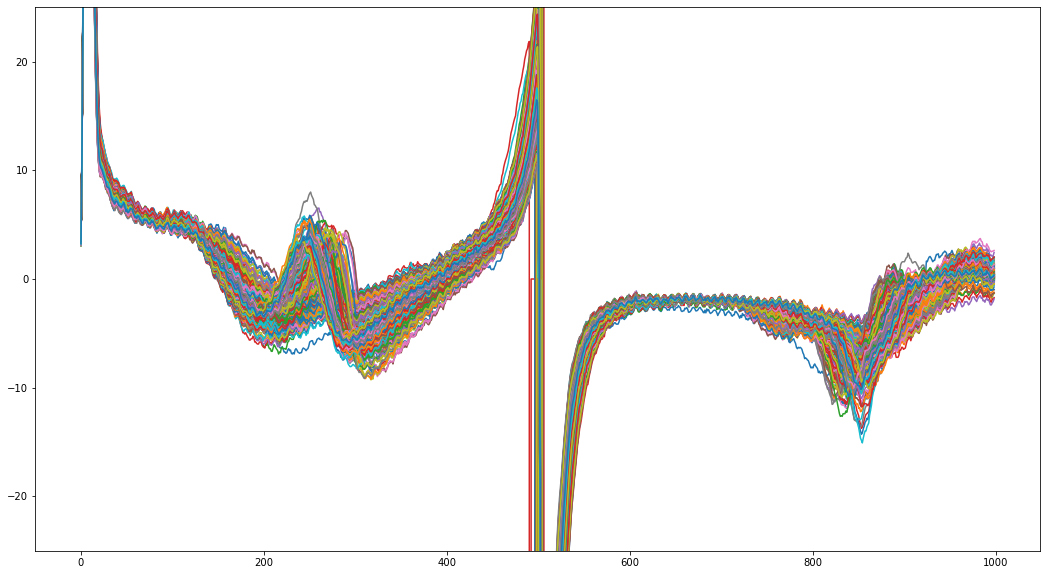

In [36]:
# data = test_data
data_x = hold_x
data_y = hold_y
vs,idxs = np.unique(data_y, axis=0, return_index=True)
plt.figure(figsize=(18,10))
for idx in idxs:
    plt.plot(hold_x[idx,:].T)
plt.ylim([-25, 25])
plt.show()
# plt.plot(np.mean(hold_x, axis=0))

In [213]:
unique_labels, uilc = np.unique(hold_y, axis=0, return_inverse=True)
for (x,y) in zip(unique_labels,np.bincount(uilc)):
    print(f'{x}: \t\t{y}')

[0.  0.  6.7 0. ]: 		150
[0.  0.  6.8 0. ]: 		150
[0.  0.  6.9 0. ]: 		300
[0. 0. 7. 0.]: 		150
[0.  0.  7.1 0. ]: 		300
[0.  0.  7.2 0. ]: 		150
[0.  0.  7.3 0. ]: 		300
[0.  0.  7.4 0. ]: 		3750
[ 0.   0.   7.4 29. ]: 		150
[  0.    0.    7.4 105. ]: 		150
[  0.    0.    7.4 152. ]: 		150
[  0.    0.    7.4 205. ]: 		150
[  0.    0.    7.4 242. ]: 		150
[  0.    0.    7.4 306. ]: 		150
[  0.    0.    7.4 350. ]: 		150
[  0.    0.    7.4 402. ]: 		150
[  0.    0.    7.4 472. ]: 		150
[  0.    0.    7.4 499. ]: 		150
[  0.    0.    7.4 554. ]: 		150
[  0.    0.    7.4 579. ]: 		150
[  0.    0.    7.4 644. ]: 		150
[  0.    0.    7.4 691. ]: 		150
[  0.    0.    7.4 743. ]: 		150
[  0.    0.    7.4 797. ]: 		150
[  0.    0.    7.4 856. ]: 		150
[  0.    0.    7.4 898. ]: 		150
[  0.    0.    7.4 951. ]: 		150
[   0.     0.     7.4 1008. ]: 		150
[   0.     0.     7.4 1051. ]: 		150
[   0.     0.     7.4 1094. ]: 		150
[   0.     0.     7.4 1153. ]: 		150
[   0.     0.     7.4 1194. ]: 	

In [225]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

nlabels = 3 # number of unique labels to consider
nsweeps = 50 # number of time series to concatenate
tr = .75 # 1 minus training ratio
L = 1000
td = L*int(nsweeps*tr)

test = np.zeros((nlabels,td))
predictions = np.zeros((nlabels,td))
ulidx = np.random.permutation(len(unique_labels))
for (iiu, iu) in enumerate(ulidx[:nlabels]):
    print(unique_labels[iu,:])
    #create train/test datasets
    onelabel = np.all(hold_y==unique_labels[iu,:],axis=1)
    X = hold_x[onelabel,:]
    X = X.reshape(X.shape[0] * X.shape[1])
    X = X[:L*nsweeps]
    train = X[0:len(X)-td]
    test[iiu,:] = X[len(X)-td:]

    #train the autoregression model
    model = AutoReg(train, lags=1000)
    model_fitted = model.fit()

    # print('Coefficients: %s' % model.params)

    # make predictions
    predictions[iiu,:] = model_fitted.predict(start=len(train), end=len(train)+len(test[iiu,:])-1, dynamic=False)
    # for i in range(len(predictions)):
    #     print('predicted=%f, expected=%f' % (predictions[i], test[i]))
    rmse = mean_squared_error(test[iiu,:], predictions[iiu,:])**.5
    print('Label %d test RMSE: %.3f' % (iiu, rmse))
    # plot results


[   0.  2357.     7.4    0. ]
Label 0 test RMSE: 0.195
[   0.  1123.     7.4    0. ]
Label 1 test RMSE: 0.192
[2896.     0.     7.4    0. ]
Label 2 test RMSE: 0.198


167
[   0.  2357.     7.4    0. ]
(1000, 37)
134
[   0.  1123.     7.4    0. ]
(1000, 37)
324
[2896.     0.     7.4    0. ]
(1000, 37)


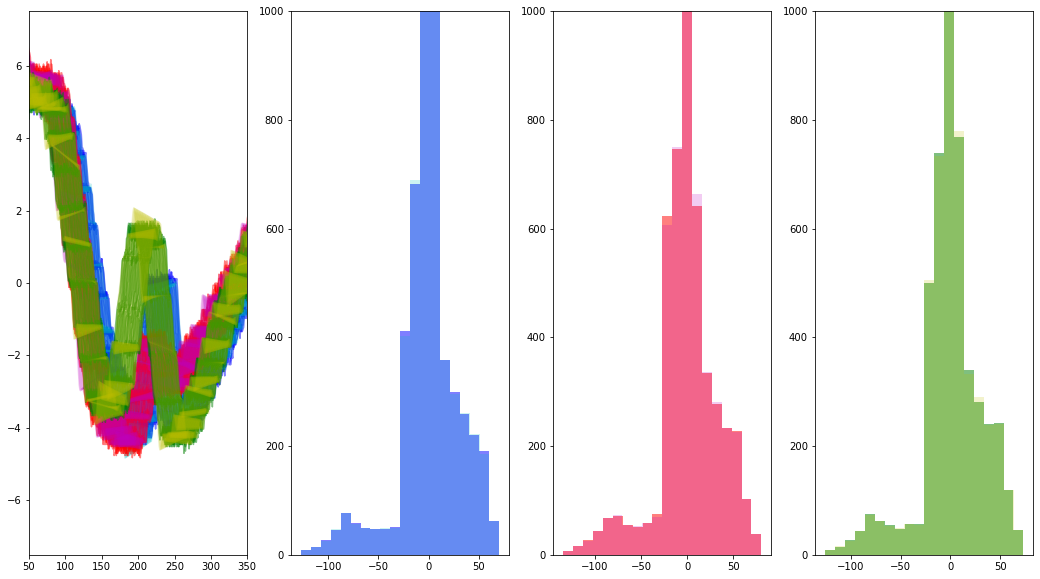

In [245]:
fig, axs = plt.subplots(1,1+nlabels)
# fig, axs = plt.subplots(1,2)
fig.set_size_inches(18,10)

c1 = ['b', 'r', 'g']
c2 = ['c', 'm', 'y']
for (iiu, iu) in enumerate(ulidx[:nlabels]):
    print(iu)
    print(unique_labels[iu,:])
    
    testm = test[iiu,:].reshape(int(test[iiu,:].shape[0]/1000), 1000).copy()
    predictionsm = predictions[iiu,:].reshape(int(test[iiu,:].shape[0]/1000), 1000).copy()
    
    print(testm.T.shape)
    axs[0].plot(testm.T, color=c1[iiu], alpha=.5)
    axs[0].plot(predictionsm.T, color=c2[iiu], alpha=.2)
    axs[0].set_ylim([-7.5,7.5])
#     axs[0].set_ylim([-10,10])
    axs[0].set_xlim([50,350])
#     axs[0].set_xlim([700,950])

    tu = np.mean(testm, axis=0)
#     ts = np.std(testm, axis=0)
    ts = np.ones(tu.shape)
    for j in range(testm.shape[1]):
        testm[:,j] = (testm[:,j]-tu[j])/ts[j]
    pu = np.mean(predictionsm, axis=0)
#     ps = np.std(predictionsm, axis=0)
    ps = np.ones(pu.shape)
    for j in range(predictionsm.shape[1]):
        predictionsm[:,j] = (predictionsm[:,j]-pu[j])/ps[j]
    axs[1+iiu].hist(testm.flatten(), color=c1[iiu], alpha=.5, bins=20)
    axs[1+iiu].hist(predictionsm.flatten(), color=c2[iiu], alpha=.2, bins=20)
    axs[1+iiu].set_ylim([0,1000])

#     axs[1].hist(testm.flatten(), color=c1[iiu], alpha=.2, bins=20)
#     axs[1].hist(predictionsm.flatten(), color=c2[iiu], alpha=.2, bins=20)


In [237]:
c1[0]

'blue'

(15000,)

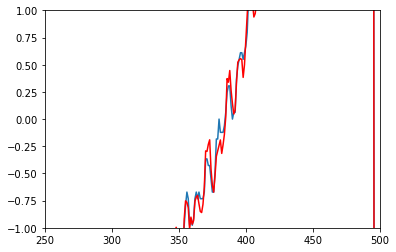

In [87]:
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.ylim([-1,1])
plt.xlim([250,500])
plt.show()


In [57]:
X.shape

(1, 61650, 999)

In [18]:
axs[i].__class__

numpy.ndarray

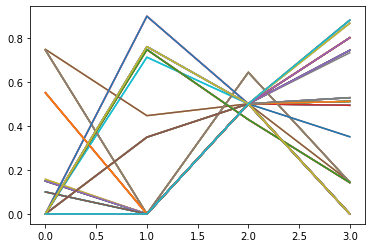

In [39]:
for i in range(len(hold_data)):
    print(len(hold_data[i]))
# plt.figure(figsize=(16,16))
ax[i.plot(hold_data[2][1][:100].T)
plt.show()

tf.Tensor([1.9996e-04 1.9996e-04 5.0000e-01 1.9996e-04], shape=(4,), dtype=float32)


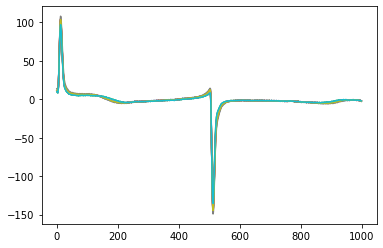

<Figure size 432x288 with 0 Axes>

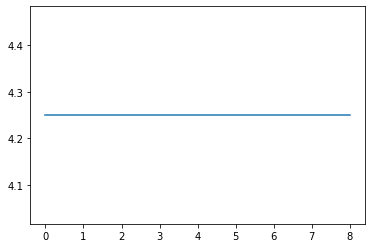

In [16]:
x0 = np_train_data[0]

for j in range(len(x0)):
    plt.figure()
    x0j = x0[j]
    if len(x0j.shape) == 1:
        plt.plot(x0j[1:10])
    else:
        if x0j.shape[1] > 20:
            for i in range(10):
                plt.plot(x0j[i,:])
        else:
            print(x0j[i,:])